In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from plotnine import *
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [ ]:
# Importing csv file from github
url = 'https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/Nenana1.csv'
nenana1_df = pd.read_csv(url)

In [ ]:
nenana1_df.head()

,Year,Date & Time
0,1917,April 30 at 11:30 AM
1,1918,May 11 at 9:33 AM
2,1919,May 3 at 2:33 PM
3,1920,May 11 at 10:46 AM
4,1921,May 11 at 6:42 AM


In [ ]:
# Putting Date & Time column into a list in order to prepare data
date_and_time = list(nenana1_df["Date & Time"])

# Empty list for new strings
datetime_str = []

# Iterating through list to obtain month and date
for n in date_and_time:
  datetime_str.append(n.split("at", 1)[0])

# Putting Year column in list
year = list(nenana1_df["Year"])

# Creating new empty list to change int to str
year_str = []

# Iterating through list and changing all items to str
for n in year:
  year_str.append(str(n))

# Using zip function to concatenate corresponding items in each list
datetime_str = [i + j for i, j in zip(datetime_str, year_str)]

# Creating empty list for KPI
kpi = []

# Iterating through list
for n in datetime_str:
  
  # Obtaining start date for each year in data
  start_date = datetime(year[datetime_str.index(n)], 1, 1).date()
  
  # Converting string objects from zipped list into datetime format
  date_object = datetime.strptime(n, '%B %d %Y').date()
  
  # Calculating difference between start dates and ice break dates and appending to new list
  date_diff = date_object - start_date
  date_string = (str(date_diff)[:3])
  kpi.append(int(date_string))

In [ ]:
# Creating new dataframe and adding corresponding years and KPI values
kpi_df = pd.DataFrame()
kpi_df["Year"] = year
kpi_df["KPI"] = kpi

kpi_df.head()

,Year,KPI
0,1917,119
1,1918,130
2,1919,122
3,1920,131
4,1921,130


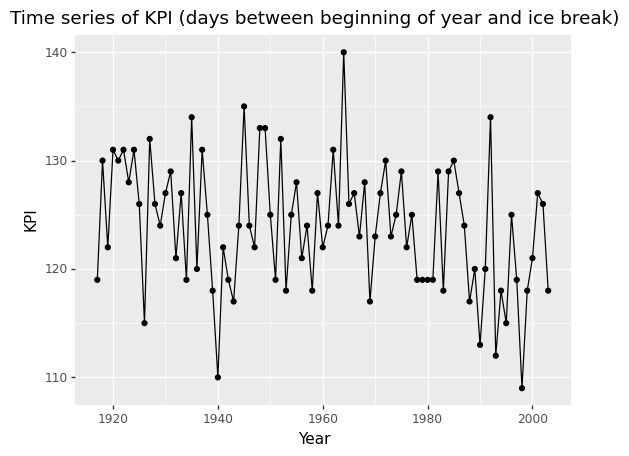

<ggplot: (8735424488325)>

In [ ]:
# Plotting Time Series
(
    ggplot(kpi_df,aes('Year','KPI', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of KPI (days between beginning of year and ice break)") +
  xlab("Year") + ylab("KPI")
    )

In [ ]:
# Calculating means of pre-1960 and post-1960 data to see difference
kpi_df['M0'] = kpi_df.loc[0:43,'KPI'].mean()
kpi_df.loc[44:,'M0'] = kpi_df.loc[44:,'KPI'].mean()

# Assigning groups
kpi_df['Group'] = "Pre-1960"
kpi_df.loc[44:,'Group'] = "Post-1960"

kpi_df['GW'] = 0
kpi_df.loc[44:,'GW'] = 1

kpi_df.head()

,Year,KPI,M0,Group,GW
0,1917,119,124.863636,Pre-1960,0
1,1918,130,124.863636,Pre-1960,0
2,1919,122,124.863636,Pre-1960,0
3,1920,131,124.863636,Pre-1960,0
4,1921,130,124.863636,Pre-1960,0


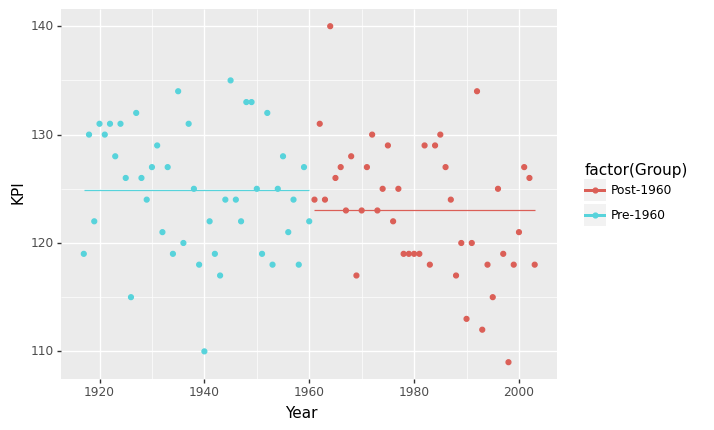

<ggplot: (8735424496949)>

In [ ]:
# Creating scatterplot with averages for both groups
(
    ggplot(kpi_df,aes('Year','KPI',color='factor(Group)')) + geom_point() + geom_line(aes('Year','M0'))
    )

In [ ]:
# Conduct ab test for KPI:
ss.ttest_ind(a=kpi_df.loc[0:43,'KPI'],b=kpi_df.loc[44:,'KPI'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=1.4660459383247382, pvalue=0.07317438616169493)

In [ ]:
(kpi_df.loc[44:,'KPI'].mean() - kpi_df.loc[:43,'KPI'].mean()) / kpi_df.loc[:43,'KPI'].mean() *100

-1.4925373134328328

In [ ]:
# Regression model
M2 = smf.ols('KPI ~ GW',data = kpi_df).fit()

print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.152
Date:                Sat, 17 Sep 2022   Prob (F-statistic):              0.146
Time:                        00:03:54   Log-Likelihood:                -277.21
No. Observations:                  87   AIC:                             558.4
Df Residuals:                      85   BIC:                             563.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.8636      0.893    139.808      0.0

In [ ]:
# Store fitted values of model in data table
kpi_df['M2'] = M2.fittedvalues

kpi_df.head()

,Year,KPI,M0,Group,GW,M2
0,1917,119,124.863636,Pre-1960,0,124.863636
1,1918,130,124.863636,Pre-1960,0,124.863636
2,1919,122,124.863636,Pre-1960,0,124.863636
3,1920,131,124.863636,Pre-1960,0,124.863636
4,1921,130,124.863636,Pre-1960,0,124.863636


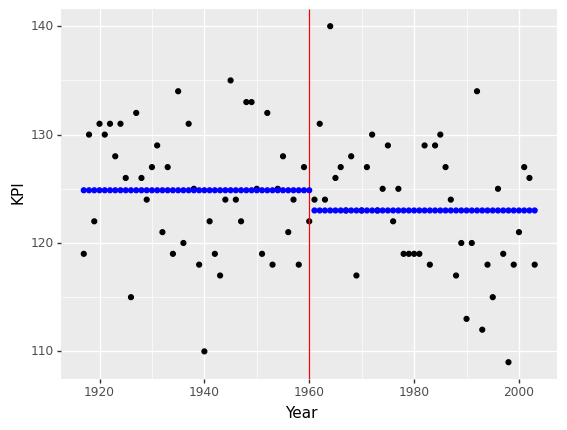

<ggplot: (8735424488289)>

In [ ]:
# Create a scatter plot of KPI to observe change
(
    ggplot(kpi_df, aes('Year','KPI')) + geom_point() + 
 geom_vline(xintercept=1960,color='red') + geom_point(aes('Year','M2'),color='blue')
)

In [ ]:
kpi_df.iloc[44:,].shape

(43, 6)

In [ ]:
# Create a ramp variable to model gradual change in KPI after 1960
kpi_df['Ramp'] = 0
kpi_df.loc[44:,'Ramp'] = list(range(44))[1:]

kpi_df.head(100)

,Year,KPI,M0,Group,GW,M2,Ramp
0,1917,119,124.863636,Pre-1960,0,124.863636,0
1,1918,130,124.863636,Pre-1960,0,124.863636,0
2,1919,122,124.863636,Pre-1960,0,124.863636,0
3,1920,131,124.863636,Pre-1960,0,124.863636,0
4,1921,130,124.863636,Pre-1960,0,124.863636,0
...,...,...,...,...,...,...,...
82,1999,118,123.000000,Post-1960,1,123.000000,39
83,2000,121,123.000000,Post-1960,1,123.000000,40
84,2001,127,123.000000,Post-1960,1,123.000000,41
85,2002,126,123.000000,Post-1960,1,123.000000,42


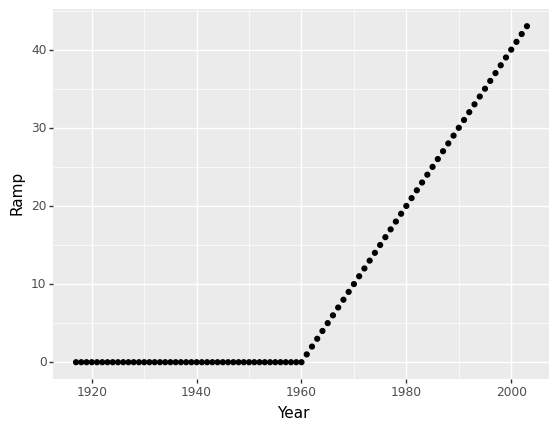

<ggplot: (8735424407053)>

In [ ]:
# visualize Ramp variable
(
    ggplot(kpi_df,aes('Year','Ramp')) + geom_point()
)

In [ ]:
# Build a regression model to assess the significance of the gradual effect of the intervention
# Model KPI = b0 + b1*Ramp
M3 = smf.ols('KPI ~ Ramp',data = kpi_df).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     9.321
Date:                Sat, 17 Sep 2022   Prob (F-statistic):            0.00302
Time:                        00:03:55   Log-Likelihood:                -273.77
No. Observations:                  87   AIC:                             551.5
Df Residuals:                      85   BIC:                             556.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.3862      0.772    162.368      0.0

In [ ]:
# Save Model M3 fitted values
kpi_df['M3'] = M3.fittedvalues

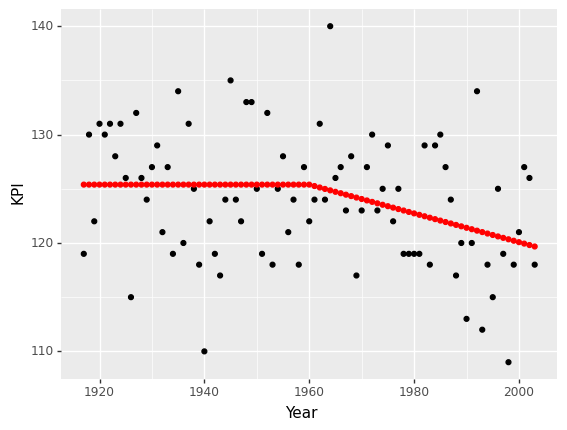

<ggplot: (8735424466389)>

In [ ]:
# Create a scatter plot of KPI with results of ramp model
(
    ggplot(kpi_df, aes('Year','KPI')) + geom_point() + 
 geom_point(aes('Year','M3'),color='red')
)

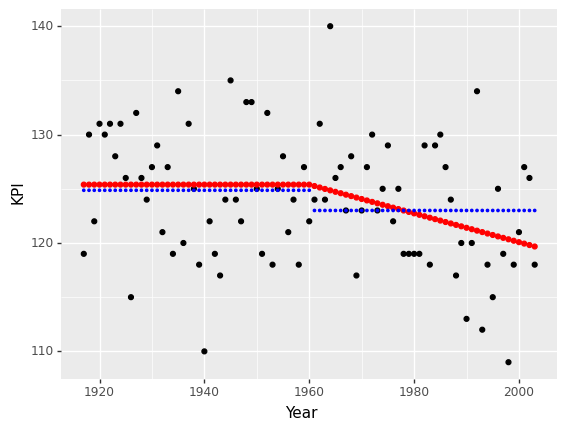

<ggplot: (8735424315529)>

In [ ]:
# compare M2 and M3 visually
(
    ggplot(kpi_df, aes('Year','KPI')) + geom_point() + 
 geom_point(aes('Year','M3'),color='red')+
 geom_point(aes('Year','M2'),color='blue',size= 0.5)
)

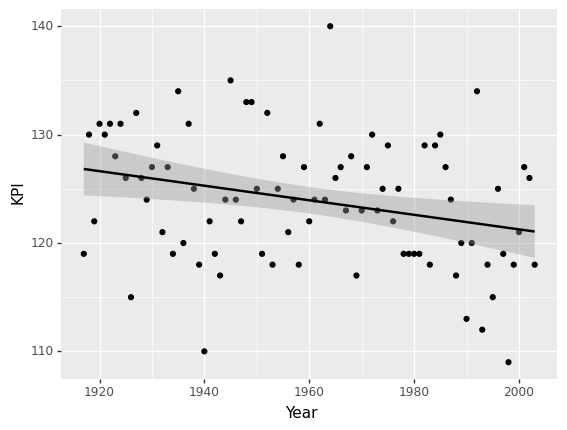

<ggplot: (8735424300529)>

In [ ]:
# Visualization that can help pick a model 
# method='lm' = linear model (regression model)
(
    ggplot(kpi_df,aes('Year','KPI')) + geom_point() +
 geom_smooth(method='lm')
)

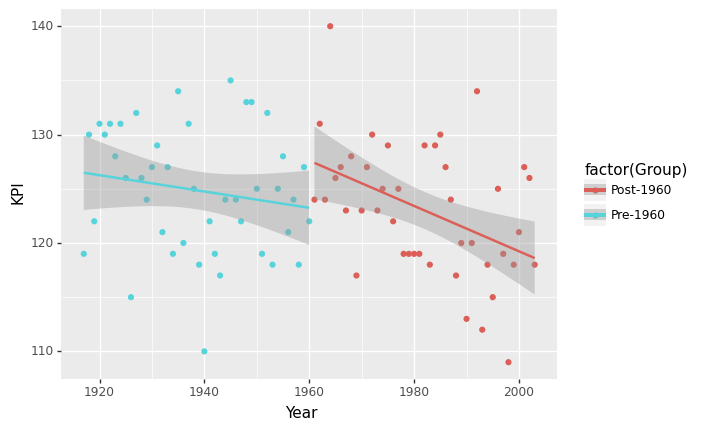

<ggplot: (8735424317637)>

In [ ]:
(
    ggplot(kpi_df,aes('Year','KPI',color='factor(Group)')) + geom_point() +
 geom_smooth(method='lm')
)

In [ ]:
# Importing csv file from github
urln2 = 'https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/Nenana2.csv'
n2_df = pd.read_csv(urln2)

In [ ]:
# Putting Date & Time column into a list in order to prepare data
date_and_time = list(n2_df["Date & Time"])

# Empty list for new strings
datetime_str = []

# Iterating through list to obtain month and date
for n in date_and_time:
  datetime_str.append(n.split("at", 1)[0])

# Putting Year column in list
year = list(n2_df["Year"])

# Creating new empty list to change int to str
year_str = []

# Iterating through list and changing all items to str
for n in year:
  year_str.append(str(n))

# Using zip function to concatenate corresponding items in each list
datetime_str = [i + j for i, j in zip(datetime_str, year_str)]

# Creating empty list for KPI
kpi = []

# Iterating through list
for n in datetime_str:
  
  # Obtaining start date for each year in data
  start_date = datetime(year[datetime_str.index(n)], 1, 1).date()
  
  # Converting string objects from zipped list into datetime format
  date_object = datetime.strptime(n, '%B %d %Y').date()
  
  # Calculating difference between start dates and ice break dates and appending to new list
  date_diff = date_object - start_date
  date_string = (str(date_diff)[:3])
  kpi.append(int(date_string))

In [ ]:
# Creating new dataframe and adding corresponding years and KPI values
df2 = pd.DataFrame()
df2["Year"] = year
df2["KPI"] = kpi

df2.tail()

,Year,KPI
100,2017,120
101,2018,120
102,2019,103
103,2020,117
104,2021,119


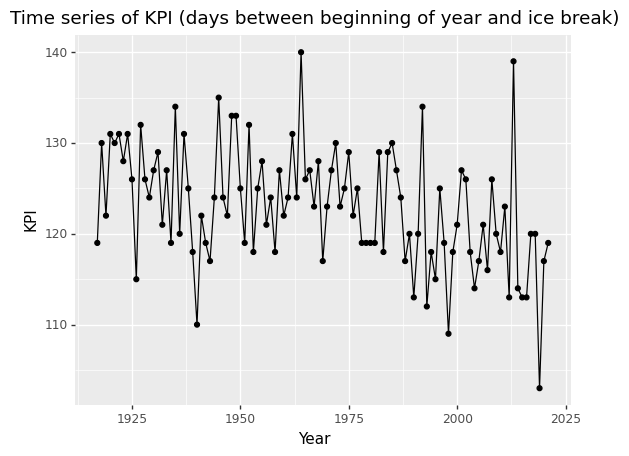

<ggplot: (8735429406205)>

In [ ]:
# Plotting Time Series
(
    ggplot(df2,aes('Year','KPI', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of KPI (days between beginning of year and ice break)") +
  xlab("Year") + ylab("KPI")
    )

In [ ]:
# Calculating means of pre-1960 and post-1960 data to see difference
df2['M0'] = df2.loc[0:43,'KPI'].mean()
df2.loc[44:,'M0'] = df2.loc[44:,'KPI'].mean()

# Assigning groups
df2['Group'] = "Pre-1960"
df2.loc[44:,'Group'] = "Post-1960"

df2['GW'] = 0
df2.loc[44:,'GW'] = 1

df2.tail()

,Year,KPI,M0,Group,GW
100,2017,120,121.557377,Post-1960,1
101,2018,120,121.557377,Post-1960,1
102,2019,103,121.557377,Post-1960,1
103,2020,117,121.557377,Post-1960,1
104,2021,119,121.557377,Post-1960,1


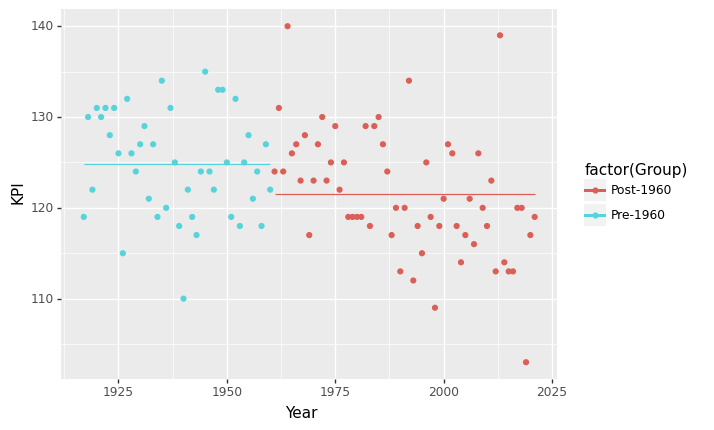

<ggplot: (8735425749165)>

In [ ]:
# Creating scatterplot with averages for both groups
(
    ggplot(df2,aes('Year','KPI',color='factor(Group)')) + geom_point() + geom_line(aes('Year','M0'))
    )

In [ ]:
# Conduct ab test for KPI:
ss.ttest_ind(a=df2.loc[0:43,'KPI'],b=df2.loc[44:,'KPI'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=2.6951329122689045, pvalue=0.004126546758520248)

In [ ]:
(df2.loc[44:,'KPI'].mean() - df2.loc[:43,'KPI'].mean()) / df2.loc[:43,'KPI'].mean() *100

-2.6478960654544093

In [ ]:
# Regression model
M2n2 = smf.ols('KPI ~ GW',data = df2).fit()

print(M2n2.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     6.892
Date:                Sat, 17 Sep 2022   Prob (F-statistic):            0.00998
Time:                        00:03:57   Log-Likelihood:                -342.36
No. Observations:                 105   AIC:                             688.7
Df Residuals:                     103   BIC:                             694.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    124.8636      0.960    130.073      0.0

In [ ]:
# Store fitted values of model in data table
df2['M2n2'] = M2n2.fittedvalues

df2.head()

,Year,KPI,M0,Group,GW,M2n2
0,1917,119,124.863636,Pre-1960,0,124.863636
1,1918,130,124.863636,Pre-1960,0,124.863636
2,1919,122,124.863636,Pre-1960,0,124.863636
3,1920,131,124.863636,Pre-1960,0,124.863636
4,1921,130,124.863636,Pre-1960,0,124.863636


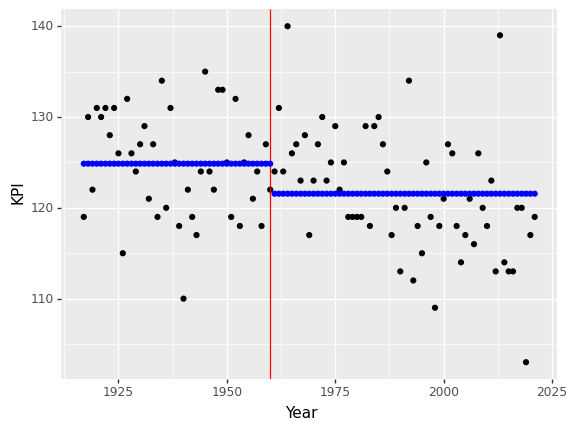

<ggplot: (8735424355101)>

In [ ]:
# Create a scatter plot of KPI to observe change
(
    ggplot(df2, aes('Year','KPI')) + geom_point() + 
 geom_vline(xintercept=1960,color='red') + geom_point(aes('Year','M2n2'),color='blue')
)

In [ ]:
df2.iloc[44:,].shape

(61, 6)

In [ ]:
# Create a ramp variable to model gradual change in KPI after 1960
df2['Ramp'] = 0
df2.loc[44:,'Ramp'] = list(range(62))[1:]

df2.head(150)

,Year,KPI,M0,Group,GW,M2n2,Ramp
0,1917,119,124.863636,Pre-1960,0,124.863636,0
1,1918,130,124.863636,Pre-1960,0,124.863636,0
2,1919,122,124.863636,Pre-1960,0,124.863636,0
3,1920,131,124.863636,Pre-1960,0,124.863636,0
4,1921,130,124.863636,Pre-1960,0,124.863636,0
...,...,...,...,...,...,...,...
100,2017,120,121.557377,Post-1960,1,121.557377,57
101,2018,120,121.557377,Post-1960,1,121.557377,58
102,2019,103,121.557377,Post-1960,1,121.557377,59
103,2020,117,121.557377,Post-1960,1,121.557377,60


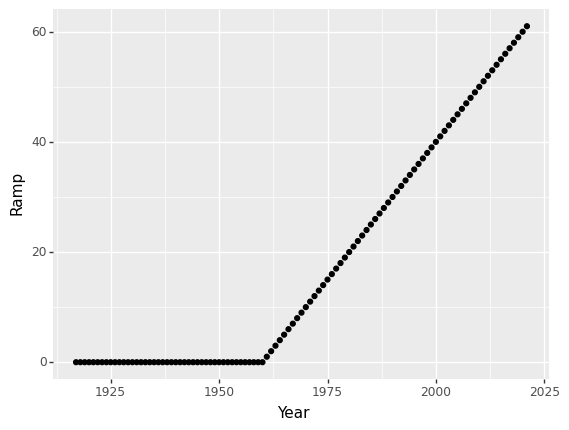

<ggplot: (8735424744641)>

In [ ]:
# visualize Ramp variable
(
    ggplot(df2,aes('Year','Ramp')) + geom_point()
)

In [ ]:
# Build a regression model to assess the significance of the gradual effect of the intervention
# Model KPI = b0 + b1*Ramp
M3n2 = smf.ols('KPI ~ Ramp',data = df2).fit()
print(M3n2.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     23.65
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           4.17e-06
Time:                        00:03:58   Log-Likelihood:                -334.91
No. Observations:                 105   AIC:                             673.8
Df Residuals:                     103   BIC:                             679.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.4341      0.773    162.268      0.0

In [ ]:
# Save Model fitted values
df2['M3n2'] = M3n2.fittedvalues

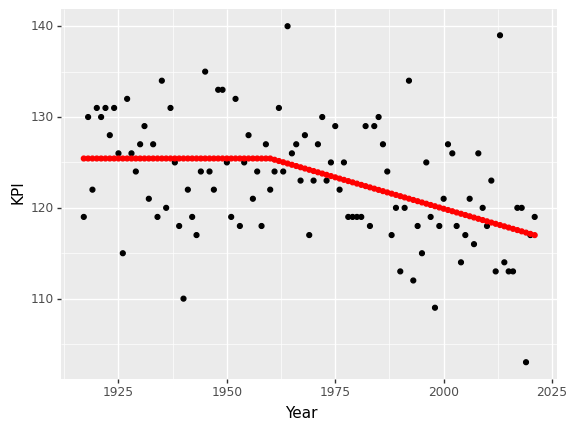

<ggplot: (8735426229349)>

In [ ]:
# Create a scatter plot of KPI with results of ramp model
(
    ggplot(df2, aes('Year','KPI')) + geom_point() + 
 geom_point(aes('Year','M3n2'),color='red')
)

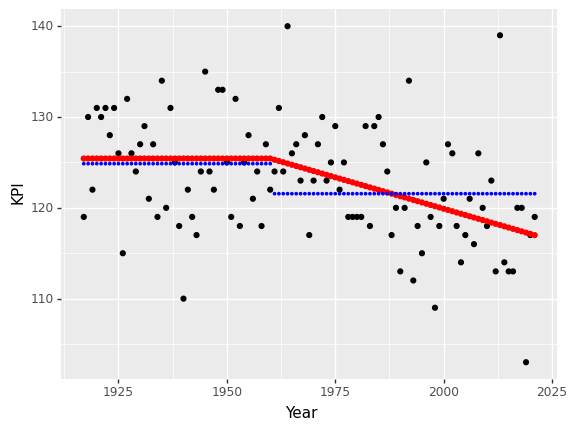

<ggplot: (8735426683361)>

In [ ]:
# compare M2n2 and M3n2 visually
(
    ggplot(df2, aes('Year','KPI')) + geom_point() + 
 geom_point(aes('Year','M3n2'),color='red') +
 geom_point(aes('Year','M2n2'),color='blue',size= 0.5)
)

**CASE 2**

In [ ]:
# Importing csv file from github
url2 = "https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/dtwnLAozone.csv"
data3 = pd.read_csv(url2)

In [ ]:
data3.head()


,Series R MONTHLY AVERAGES OF HOURLY READINGS OF OZONE IN DOWNTOWN LOS ANGELES,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Jan.,Feb.,Mar.,Apr.,May,June,July,Aug.,Sept.,Oct.,Nov.,Dec.
2,1955.0,2.63,1.94,3.38,4.92,6.29,5.58,5.5,4.71,6.04,7.13,7.79,3.83
3,1956.0,3.83,4.25,5.29,3.75,4.67,5.42,6.04,5.71,8.13,4.88,5.42,5.5
4,1957.0,3,3.42,4.5,4.25,4,5.33,5.79,6.58,7.29,5.04,5.04,4.48


In [ ]:
# Grabbing months from data and popping Nan
months_list = (list(data3.iloc[1]))
months_list.pop(0)

# Creating list with full month names
full_month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Changing values of original list
for n in range(12):
  months_list[n] = full_month_list[n]

print(months_list)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [ ]:
# Grabbing years
years_list = list(data3[' Series R   MONTHLY AVERAGES OF HOURLY READINGS OF OZONE IN DOWNTOWN LOS ANGELES'])

# Removing Nan
for n in range(2):
  years_list.pop(0)

# Creating new list
year_str_list = []

# Adding years as strings and removing decimals
for n in range(18):
  year_str_list.append(str(years_list[n])[:4])

print(year_str_list)

['1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972']


In [ ]:
# Creating empty list for new dates
date_list = []

# Iterating through lists in order to concatenate months and years
for n in range(18):
  year = year_str_list[n]
  for n in range(12):
    month = months_list[n]
    date_list.append((month + " " + year))

# Creating empty list for datetimes
datetime_list = []

# Iterating through date string list to convert to datetime and append to new list
for n in range(216):
  datetime_object = datetime.strptime(date_list[n], '%B %Y').date()
  datetime_list.append(datetime_object)

print(datetime_list)

[datetime.date(1955, 1, 1), datetime.date(1955, 2, 1), datetime.date(1955, 3, 1), datetime.date(1955, 4, 1), datetime.date(1955, 5, 1), datetime.date(1955, 6, 1), datetime.date(1955, 7, 1), datetime.date(1955, 8, 1), datetime.date(1955, 9, 1), datetime.date(1955, 10, 1), datetime.date(1955, 11, 1), datetime.date(1955, 12, 1), datetime.date(1956, 1, 1), datetime.date(1956, 2, 1), datetime.date(1956, 3, 1), datetime.date(1956, 4, 1), datetime.date(1956, 5, 1), datetime.date(1956, 6, 1), datetime.date(1956, 7, 1), datetime.date(1956, 8, 1), datetime.date(1956, 9, 1), datetime.date(1956, 10, 1), datetime.date(1956, 11, 1), datetime.date(1956, 12, 1), datetime.date(1957, 1, 1), datetime.date(1957, 2, 1), datetime.date(1957, 3, 1), datetime.date(1957, 4, 1), datetime.date(1957, 5, 1), datetime.date(1957, 6, 1), datetime.date(1957, 7, 1), datetime.date(1957, 8, 1), datetime.date(1957, 9, 1), datetime.date(1957, 10, 1), datetime.date(1957, 11, 1), datetime.date(1957, 12, 1), datetime.date(1958

In [ ]:
# Creating empty list for ozone values
value_list = []

# Iterating through rows to grab values and remove Nan
for n in range(2,20): 
  value_row = (list(data3.iloc[n]))
  value_row.pop(0)
  
  # Appending individual values to new list
  for n in range(12):
    value_list.append(float(value_row[n]))

print(value_list)

[2.63, 1.94, 3.38, 4.92, 6.29, 5.58, 5.5, 4.71, 6.04, 7.13, 7.79, 3.83, 3.83, 4.25, 5.29, 3.75, 4.67, 5.42, 6.04, 5.71, 8.13, 4.88, 5.42, 5.5, 3.0, 3.42, 4.5, 4.25, 4.0, 5.33, 5.79, 6.58, 7.29, 5.04, 5.04, 4.48, 3.33, 2.88, 2.5, 3.83, 4.17, 4.42, 4.25, 4.08, 4.88, 4.54, 4.25, 4.21, 2.75, 2.42, 4.5, 5.21, 4.0, 7.54, 7.38, 5.96, 5.08, 5.46, 4.79, 2.67, 1.71, 1.92, 3.38, 3.98, 4.63, 4.88, 5.17, 4.83, 5.29, 3.71, 2.46, 2.17, 2.15, 2.44, 2.54, 3.25, 2.81, 4.21, 4.13, 4.17, 3.75, 3.83, 2.42, 2.17, 2.33, 2.0, 2.13, 4.46, 3.17, 3.25, 4.08, 5.42, 4.5, 4.88, 2.83, 2.75, 1.63, 3.04, 2.58, 2.92, 3.29, 3.71, 4.88, 4.63, 4.83, 3.42, 2.38, 2.33, 1.5, 2.25, 2.63, 2.96, 3.46, 4.33, 5.42, 4.79, 4.38, 4.54, 2.04, 1.33, 2.04, 2.81, 2.67, 4.08, 3.9, 3.96, 4.5, 5.58, 4.52, 5.88, 3.67, 1.79, 1.71, 1.92, 3.58, 4.4, 3.79, 5.52, 5.5, 5.0, 5.48, 4.81, 2.42, 1.46, 1.71, 2.46, 2.42, 1.79, 3.63, 3.54, 4.88, 4.96, 3.63, 5.46, 3.08, 1.75, 2.13, 2.58, 2.75, 3.15, 3.46, 3.33, 4.67, 4.13, 4.73, 3.42, 3.08, 1.79, 1.96, 1

In [ ]:
# Creating new dataframe and adding corresponding dates and values
df = pd.DataFrame()
df["Date"] = datetime_list
df["Ozone"] = value_list

df.tail()

,Date,Ozone
211,1972-08-01,3.92
212,1972-09-01,3.08
213,1972-10-01,2.00
214,1972-11-01,1.58
215,1972-12-01,1.21


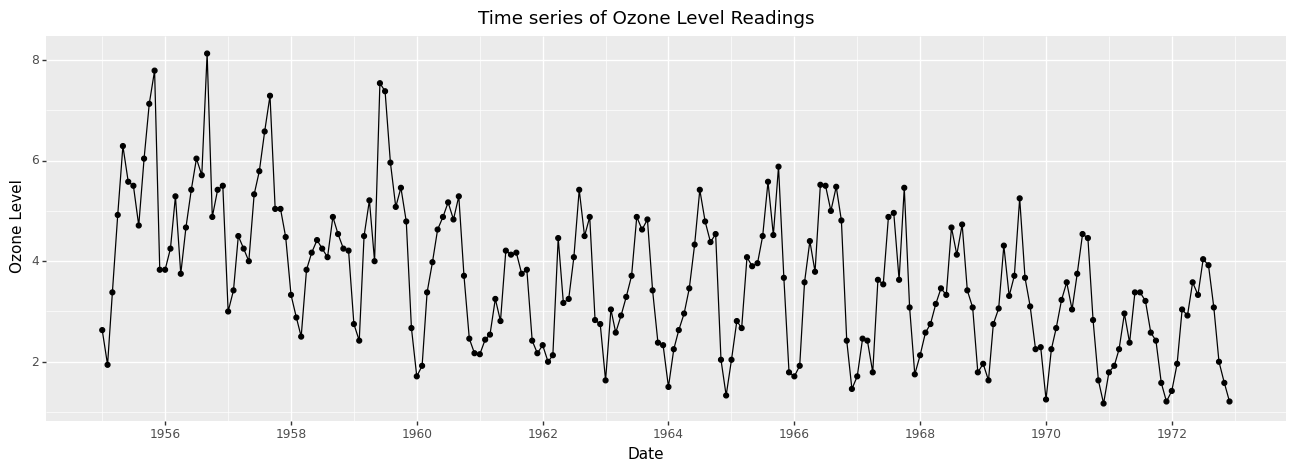

<ggplot: (8735426030101)>

In [ ]:
# Plotting Time Series
(
    ggplot(df,aes('Date','Ozone', group = 1)) + geom_point() + geom_line() + ggtitle("Time series of Ozone Level Readings") +
  xlab("Date") + ylab("Ozone Level") + theme(figure_size=(16, 5)) + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
    )

In [ ]:
# Calculating means of pre-1960 and post-1960 data to see difference
df['M0'] = df.loc[0:60,'Ozone'].mean()
df.loc[61:,'M0'] = df.loc[61:,'Ozone'].mean()

# Assigning groups
df['Group'] = "Pre-1960"
df.loc[61:,'Group'] = "Post-1960"

df['R63'] = 0
df.loc[61:,'R63'] = 1

df.head()

,Date,Ozone,M0,Group,R63
0,1955-01-01,2.63,4.723934,Pre-1960,0
1,1955-02-01,1.94,4.723934,Pre-1960,0
2,1955-03-01,3.38,4.723934,Pre-1960,0
3,1955-04-01,4.92,4.723934,Pre-1960,0
4,1955-05-01,6.29,4.723934,Pre-1960,0


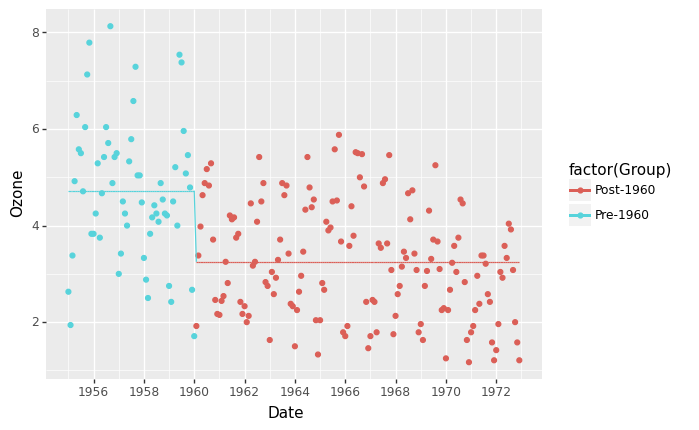

<ggplot: (8735425789197)>

In [ ]:
# Creating scatterplot with averages for both groups
(
    ggplot(df,aes('Date','Ozone',color='factor(Group)')) + geom_point() + geom_line(aes('Date','M0', group = 1)) 
    + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
    )

In [ ]:
# Conduct ab test for Ozone Level:
ss.ttest_ind(a=df.loc[0:60,'Ozone'],b=df.loc[61:,'Ozone'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=7.126903029472276, pvalue=1.0784110381513362e-10)

In [ ]:
# Regression model
M2 = smf.ols('Ozone ~ R63', data = df).fit()

print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     60.61
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           2.95e-13
Time:                        00:04:00   Log-Likelihood:                -354.18
No. Observations:                 216   AIC:                             712.4
Df Residuals:                     214   BIC:                             719.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7239      0.160     29.449      0.0

In [ ]:
# Store fitted values of model in data table
df['M2'] = M2.fittedvalues

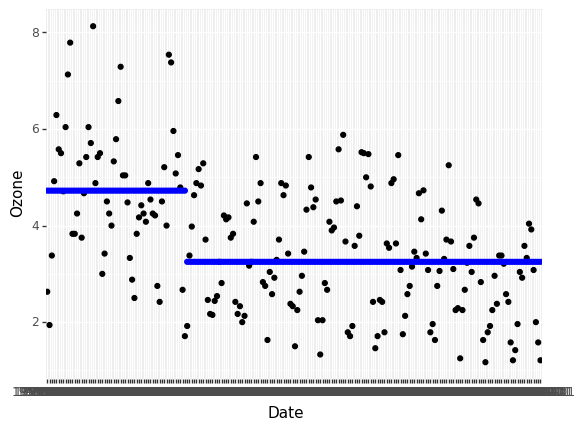

<ggplot: (8735424433725)>

In [ ]:
# Create a scatter plot for M2
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_vline(xintercept=1960-1-1,color='red') + geom_point(aes('Date','M2'),color='blue')
)

In [ ]:
df.iloc[61:,].shape

(155, 6)

In [ ]:
# Create a ramp variable to model gradual change in Ozone after 1960
df['Ramp'] = 0
df.loc[61:,'Ramp'] = list(range(156))[1:]

df

,Date,Ozone,M0,Group,R63,M2,Ramp
0,1955-01-01,2.63,4.723934,Pre-1960,0,4.723934,0
1,1955-02-01,1.94,4.723934,Pre-1960,0,4.723934,0
2,1955-03-01,3.38,4.723934,Pre-1960,0,4.723934,0
3,1955-04-01,4.92,4.723934,Pre-1960,0,4.723934,0
4,1955-05-01,6.29,4.723934,Pre-1960,0,4.723934,0
...,...,...,...,...,...,...,...
211,1972-08-01,3.92,3.249742,Post-1960,1,3.249742,151
212,1972-09-01,3.08,3.249742,Post-1960,1,3.249742,152
213,1972-10-01,2.00,3.249742,Post-1960,1,3.249742,153
214,1972-11-01,1.58,3.249742,Post-1960,1,3.249742,154


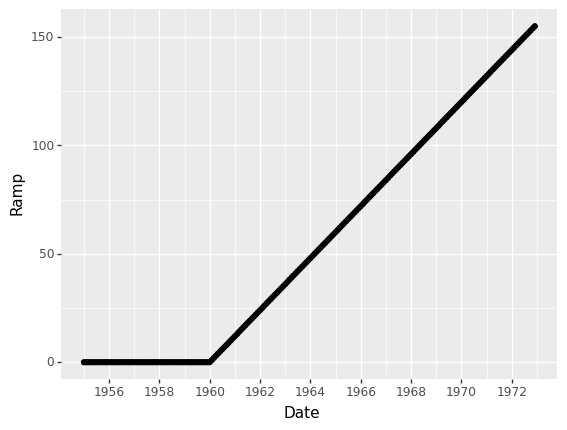

<ggplot: (8735426217665)>

In [ ]:
# visualize Ramp variable
(
    ggplot(df,aes('Date','Ramp')) + geom_point() + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

In [ ]:
# Build a regression model to assess the significance of the gradual effect of the R63 intervention
# Model Ozone = b0 + b1*Ramp
M3 = smf.ols('Ozone ~ Ramp',data = df).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     51.69
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           1.07e-11
Time:                        00:04:08   Log-Likelihood:                -357.74
No. Observations:                 216   AIC:                             719.5
Df Residuals:                     214   BIC:                             726.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3410      0.128     33.975      0.0

In [ ]:
df['M3'] = M3.fittedvalues

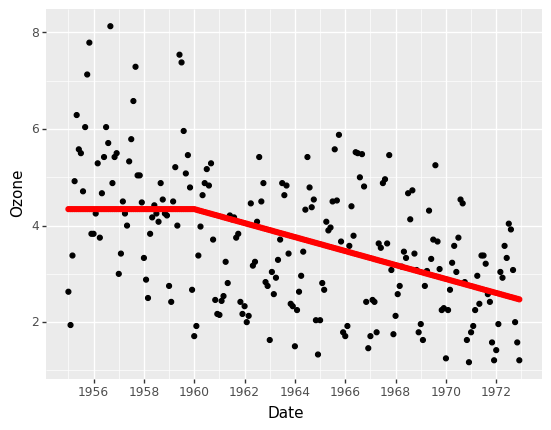

<ggplot: (8735424388721)>

In [ ]:
# Create a scatter plot of KPI with results of ramp model
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_point(aes('Date','M3'),color='red') + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

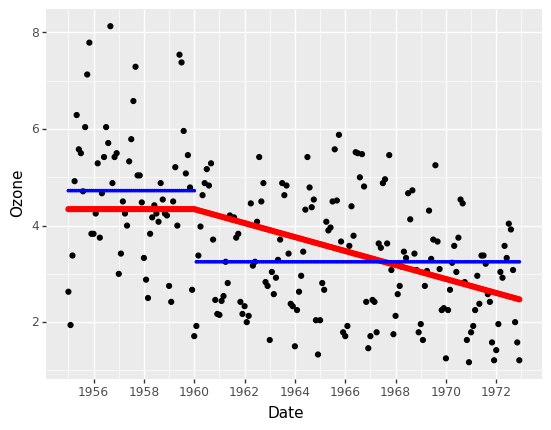

<ggplot: (8735424425213)>

In [ ]:
# compare M2 and M3 visually
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_point(aes('Date','M3'),color='red') +
 geom_point(aes('Date','M2'),color='blue',size= 0.5) + 
 scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

In [ ]:
df.loc[132]

Date     1966-01-01
Ozone          1.71
M0         3.249742
Group     Post-1960
R63               1
M2         3.249742
Ramp             72
M3         3.472782
Name: 132, dtype: object

In [ ]:
# Calculating means of pre-1966 and post-1966 data to see difference
df['M0b'] = df.loc[0:132,'Ozone'].mean()
df.loc[133:,'M0b'] = df.loc[133:,'Ozone'].mean()

# Assigning groups for engine regulations in 1966
df['Group2'] = "Pre-1966"
df.loc[133:,'Group2'] = "Post-1966"

df['ENG'] = 0
df.loc[133:,'ENG'] = 1

df.head()

,Date,Ozone,M0,Group,R63,M2,Ramp,M3,M0b,Group2,ENG
0,1955-01-01,2.63,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0
1,1955-02-01,1.94,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0
2,1955-03-01,3.38,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0
3,1955-04-01,4.92,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0
4,1955-05-01,6.29,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0


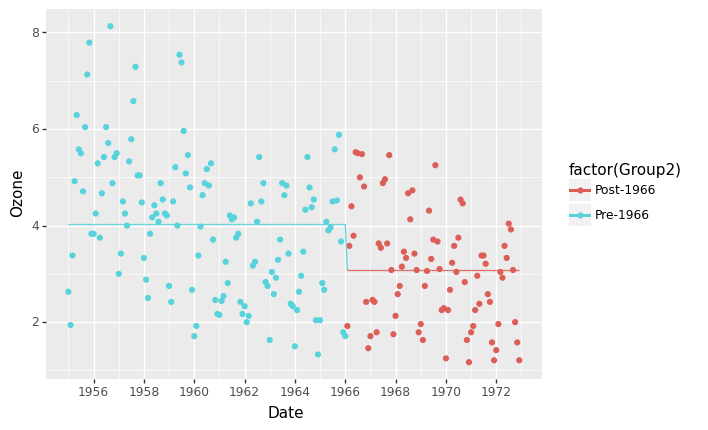

<ggplot: (8735424608509)>

In [ ]:
# Creating scatterplot with averages for both groups
(
    ggplot(df,aes('Date','Ozone',color='factor(Group2)')) + geom_point() + geom_line(aes('Date','M0b', group = 1)) 
    + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
    )

In [ ]:
# Conduct ab test for Ozone Level after engine regs:
ss.ttest_ind(a=df.loc[0:132,'Ozone'],b=df.loc[133:,'Ozone'],equal_var=False,alternative='greater')

Ttest_indResult(statistic=5.380702409682276, pvalue=1.0304021337531767e-07)

In [ ]:
# Regression model
M2b = smf.ols('Ozone ~ ENG', data = df).fit()

print(M2b.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     26.23
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           6.75e-07
Time:                        00:04:09   Log-Likelihood:                -368.62
No. Observations:                 216   AIC:                             741.2
Df Residuals:                     214   BIC:                             748.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0348      0.116     34.738      0.0

In [ ]:
# Store fitted values of model in data table
df['M2b'] = M2b.fittedvalues

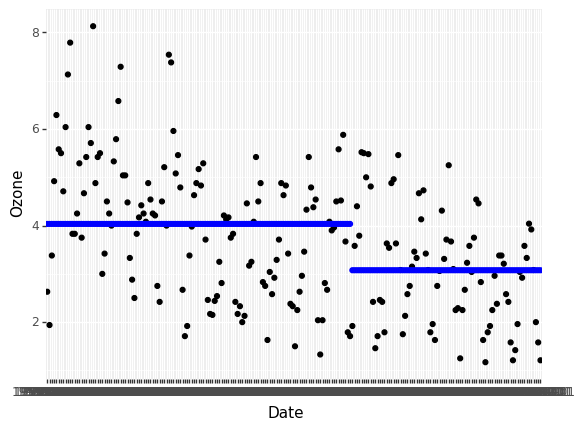

<ggplot: (8735424673201)>

In [ ]:
# Create a scatter plot for M2b
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_vline(xintercept=1960-1-1,color='red') + geom_point(aes('Date','M2b'),color='blue')
)

In [ ]:
df.iloc[133:].shape

(83, 12)

In [ ]:
# Create a ramp variable to model gradual change in Ozone after 1960
df['Ramp2'] = 0
df.loc[133:,'Ramp2'] = list(range(84))[1:]

df

,Date,Ozone,M0,Group,R63,M2,Ramp,M3,M0b,Group2,ENG,M2b,Ramp2
0,1955-01-01,2.63,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0,4.034812,0
1,1955-02-01,1.94,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0,4.034812,0
2,1955-03-01,3.38,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0,4.034812,0
3,1955-04-01,4.92,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0,4.034812,0
4,1955-05-01,6.29,4.723934,Pre-1960,0,4.723934,0,4.341047,4.034812,Pre-1966,0,4.034812,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1972-08-01,3.92,3.249742,Post-1960,1,3.249742,151,2.520103,3.075181,Post-1966,1,3.075181,79
212,1972-09-01,3.08,3.249742,Post-1960,1,3.249742,152,2.508044,3.075181,Post-1966,1,3.075181,80
213,1972-10-01,2.00,3.249742,Post-1960,1,3.249742,153,2.495985,3.075181,Post-1966,1,3.075181,81
214,1972-11-01,1.58,3.249742,Post-1960,1,3.249742,154,2.483925,3.075181,Post-1966,1,3.075181,82


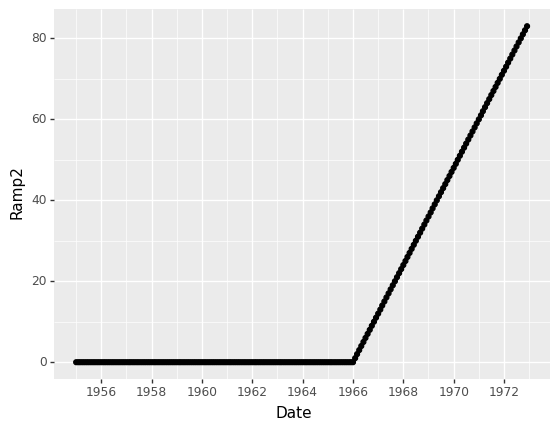

<ggplot: (8735431045553)>

In [ ]:
# visualize Ramp2 variable
(
    ggplot(df,aes('Date','Ramp2')) + geom_point() + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

In [ ]:
# Build a regression model to assess the significance of the gradual effect of the ENG intervention
# Model Ozone = b0 + b1*Ramp2
M3b = smf.ols('Ozone ~ Ramp2',data = df).fit()
print(M3b.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     34.33
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           1.74e-08
Time:                        00:04:16   Log-Likelihood:                -365.04
No. Observations:                 216   AIC:                             734.1
Df Residuals:                     214   BIC:                             740.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0017      0.106     37.617      0.0

In [ ]:
df['M3b'] = M3b.fittedvalues

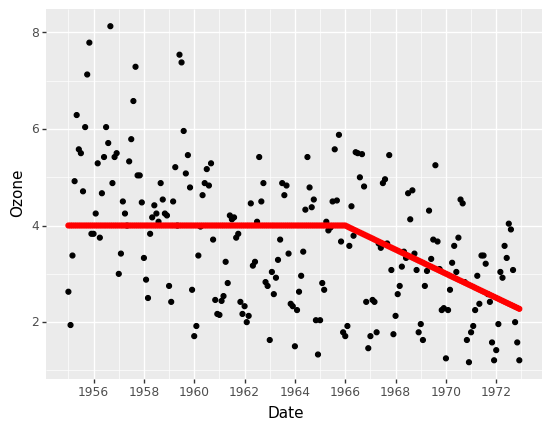

<ggplot: (8735424605237)>

In [ ]:
# Create a scatter plot of ozone with results of ramp2 model
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_point(aes('Date','M3b'),color='red') + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

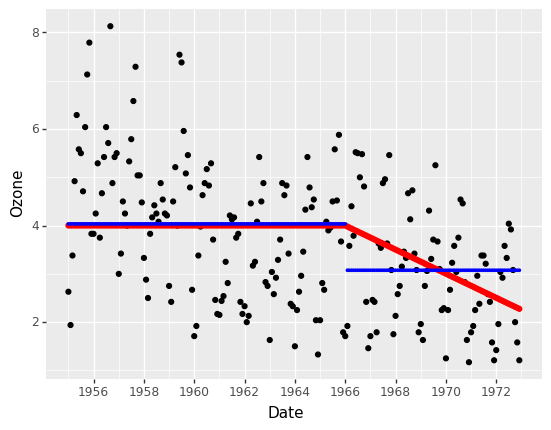

<ggplot: (8735425272801)>

In [ ]:
# compare M2b and M3b visually
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_point(aes('Date','M3b'),color='red') +
 geom_point(aes('Date','M2b'),color='blue',size= 0.5) + 
 scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)

In [ ]:
# Build a regression model to assess the significance of both abrupt and gradual effects of the BM intervention
# Model Ozone = b0 + b1*R63 + b2*Ramp2
M4 = smf.ols('Ozone ~ R63 + Ramp2',data = df).fit()
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ozone   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     37.58
Date:                Sat, 17 Sep 2022   Prob (F-statistic):           1.05e-14
Time:                        00:21:55   Log-Likelihood:                -348.47
No. Observations:                 216   AIC:                             702.9
Df Residuals:                     213   BIC:                             713.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7239      0.157     30.167      0.0

In [ ]:
df['M4'] = M4.fittedvalues

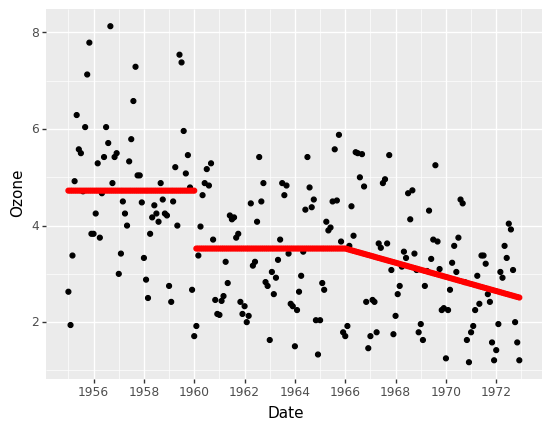

<ggplot: (8735424288993)>

In [ ]:
# Create a scatter plot of ozone with results of new model
(
    ggplot(df, aes('Date','Ozone')) + geom_point() + 
 geom_point(aes('Date','M4'),color='red') + scale_x_datetime(breaks=date_breaks('2 years'), labels=date_format('%Y'))
)